References:

* Ulmer Goodman https://arxiv.org/abs/astro-ph/9406042
* Quasi-GO approximation Takahashi https://arxiv.org/pdf/astro-ph/0402165.pdf 
* generalized NFW https://arxiv.org/pdf/astro-ph/0007354.pdf

In [32]:
import os
import sys
sys.path.insert(0, os.path.abspath('../code'))

#import diffinteg_sis as sis
import diffinteg_cis as cis

import importlib
import fourier as fou

import numpy as np
from scipy.special import hyp2f1, gamma

import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import integrate

# Basic call

In [33]:
w, F_wo_reg, lens_data = cis.cis_F_wo_reg(0.01,1.3)

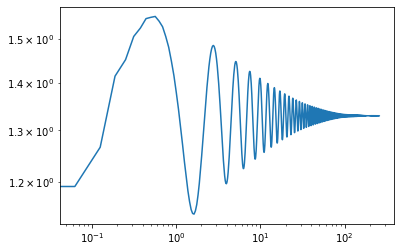

In [34]:
plt.loglog(w, np.abs(F_wo_reg))

## Total mass (SIS)

we define the mass of the halo by integrating up to a virial radius $r_{v}$ where $\rho(r_{v}) = 200\rho_c$

For SIS this leads to $M_{v} = \frac{2}{5\sqrt{6}}\frac{\sigma_v^3}{G H_0} = 1.46\cdot 10^{22}(\sigma_v/c)^3 M_\odot = 1.86\cdot 10^{11}\left(\frac{\sigma_v}{70 {\rm km/s}}\right)^3 M_\odot$

In [2]:
import astropy.units as u
import astropy.constants as c

H0 = (70*u.km/u.s/u.Mpc).decompose()
print((H0/c.c).to(1/u.Mpc))

coeff_SIS = 2./5./np.sqrt(6)/(c.G*H0/c.c**3)
coeff_SIS.decompose()
print('for sigma_v = 1: ', coeff_SIS.to(u.M_sun))
print('for sigma_v = 70km/s: %e M_sun'%(coeff_SIS.to(u.M_sun)*(70*u.km/u.s/c.c).decompose()**3/u.M_sun))

print('for sigma_v = 300km/s: %e M_sun'%(coeff_SIS.to(u.M_sun)*(300*u.km/u.s/c.c).decompose()**3/u.M_sun))

0.00023349486663870646 1 / Mpc
for sigma_v = 1:  1.4614613892708593e+22 solMass
for sigma_v = 70km/s: 1.860456e+11 M_sun
for sigma_v = 300km/s: 1.464499e+13 M_sun


### plotting utilities

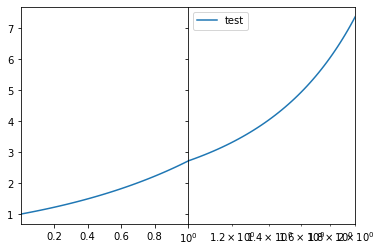

In [5]:
#plot utilities

def multiplot_reldif_setup():
    fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[1,1],'width_ratios':[0.25,0.75]},sharex='col',sharey='row') #
    plt.subplots_adjust(hspace=0.05,wspace=0.0)
    
    ax[0,0].set_xscale('log')
    ax[0,1].set_xscale('linear')
    
    return fig, ax
    
#fig, ax = multiplot_setup()

def multiplot_loglinear_setup(x_lims = 0,log_width=0.5,log_first=True):
    ''' set up a multiplot, where low x values are logarithmic
        x_lims = [xmin, xcut, xmax], so xcut divides the two regions of the plot
        log_width: relative width of the logarithmic part of the plot 
    '''
    fig, ax = plt.subplots(1,2,gridspec_kw={'width_ratios':[log_width,1-log_width]},sharey='row') #
    plt.subplots_adjust(hspace=0.05,wspace=0.0)
    
    i_lin,i_log = (0,1) if log_first else (1,0)
    
    if x_lims !=0:
        xmin, xcut, xmax = x_lims
        ax[0].set_xlim(xmin,xcut*.999) #remove a little so the two axes don't overplot
        ax[1].set_xlim(xcut,xmax)
    
    ax[i_lin].set_xscale('log')
    ax[i_log].set_xscale('linear')
    
    return fig,ax

def multiplot(ax, x,y,sty='-',**kwargs):
    ax[0].plot(x,y,sty,**kwargs)#,style,kwargs)
    ax[1].plot(x,y,sty,**kwargs)#,style,**kwargs)#


fig,ax = multiplot_loglinear_setup(x_lims = [1e-3,1,2],log_first=False)

x = np.linspace(1e-3,2,100)

multiplot(ax, x,np.exp(x),label='test')
plt.legend()

## Compute contours

In [3]:
importlib.reload(dis)

# define some parameters
# external convergence and shear; lens center; normalization of mass and angular scales, etc.
# Please refer to source code

#importlib.reload(dis)

#external convergence & shear
ka_0 = 0.0
ga1_0 = 0.0
ga2_0 = 0.0

# lens center
xc1 = 0.3
xc2 = 0.0

# fiducial source position and velocity
#y=0!
y1pt = 0.9
y2pt = 0.0

yt1pt = 0.0
yt2pt = 1.0

tmin = -6.0
tmax = 6.0

m = 1 #mass
xi0 = 1.0 #scale

lens_name = 'SIS_xc1=%g'%xc1

# create a class instance of diffraction integral evaluation
tmp = dis.DiffractionIntegral(ka_0, ga1_0, ga2_0, xc1, xc2, y1pt, y2pt, yt1pt, yt2pt, tmin, tmax, m, xi0);

In [4]:
# It is possible to solve for image positions in geometric optics
# Please refer to source code for more information

# saddle point image (S image)
xi1, xi2 = 1.1, 0 #0.5*((xc1-y1pt) -np.sqrt((xc1-y1pt)**2+4.)), 0

xS1, xS2 = tmp.EvolveImage(xi1, xi2, 0, 0, 40)
tau_S = tmp.tau(xS1, xS2)

print(xS1,xS2,tau_S)

# minimum image (L image)

xi1, xi2 = -1.1, 0#0.5*((xc1-y1pt) -np.sqrt((xc1-y1pt)**2+4.)), 0

xL1, xL2 = tmp.EvolveImage(xi1, xi2, 0, 0, 40)
tau_L = tmp.tau(xL1, xL2)
#print(tmp.xtoy(xL1, xL2))
print(xL1, xL2,tau_L)

# maximum image (H image) -> NON EXISTENT FOR POINT LENS!
# just put the cusp

eps_cusp = 0 # 1e-12

xH1, xH2 = xc1+eps_cusp,0 #tmp.EvolveImage(0.5, 0.0, 0, 0, 40)
tau_H = tmp.tau(xH1,xH2)

if eps_cusp !=0:
    print('\n NOTE: displacing the cusp by %e to avoid nan in ddphi!'%eps_cusp)

#print(xH1, xH2)
#print(tmp.tau(xH1, xH2))
#tmp.hessian(xH1, xH2)
#print(tmp.xtoy(xH1, xH2))
#print(1.0/tmp.jac(xH1, xH2))

1.0 0.0 -0.19999999999999996
-1.0 0.0 -0.8
